**Table of contents**<a id='toc0_'></a>    
- [Defining TFI model and Exact Energy Calculations](#toc1_1_)    
- [Performance analysis of Feed Forward Neural Network Quantum States](#toc2_)    
  - [Antiferromagnetic model](#toc2_1_)    
  - [Ferromagnetic Models](#toc2_2_)    
- [Variational Quantum Algorithms](#toc3_)    
  - [Anti-Ferromagnetic Model](#toc3_1_)    
  - [Ferromagnetic](#toc3_2_)    
- [Conclusion & Dicussion](#toc3_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [5]:
# importing qiskit modules

from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler import PassManager
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import BackendEstimator
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.providers.options import Options
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


In [6]:
# importing necessary netket libraries
import flax
import flax.linen as nn
import netket as nk
from netket.operator.spin import sigmax,sigmaz
import jax.numpy as jnp

In [1]:
# other useful libraries
import pickle
import sys
import time

from tqdm import tqdm
from scipy.sparse.linalg import eigsh
from scipy.optimize import minimize

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# mounting google drive (if running on google colab) --otherwise comment

# from google.colab import drive
# drive.mount('/content/drive/')

## <a id='toc1_1_'></a>[Defining TFI model and Exact Energy Calculations](#toc0_)

Transverse Field Ising Model is one othe simplest quantum system nowadays used as benchmark to test the performance of various algorithms.

$$H = -J\sum_{\langle i,j \rangle}\sigma^{z}_{i}\sigma^{z}_{j} - h\sum_{i}\sigma^{x}_{i}$$

where $J$ accounts for the spin-spin interaction strength. If $J>0$ the spins have ferromagnetic interaction between them and $J<
1$ indicates antiferromagnetic interaction. Each spin in the chain is under the influence of the an external field in the $x$ direction, whose strength is indicated by $h$.
 - $h=0$ indicates no field.
 - $h$ takes negative values the field is in the $-x$ direction.

### Ground State as a Variational Problem

According to the variational principle of quantum mechanics, the problem of finding the ground state of the system can be mapped into a optimization problem. The trail wavefunction whose parameter is optimized during the process is called an ansatz. At the end of the optimization we will a set of optimal parameters which then supplied to ansatz would give approximate ground state of the system studied.


There are many kind of ansatz which having there on strength and weakness. In this notebook, we are going to compare the performance of
[Neural Network Quantum States](https://arxiv.org/pdf/2402.09402.pdf) and [Variational Quantum Algorithms](https://www.sciencedirect.com/science/article/pii/S0370157322003118?via%3Dihub). 

* **Neural Network Quantum States**: uses neural networks as variational ansatz whose weights and biased are optimized to find the ground states of the system of interest. It was first by [G.Carleo and M.Troyer](https://arxiv.org/pdf/1606.02318.pdf) in 2017. The application of NQS extends far beyond finding ground state of the system.
    * In this excercise, we have used one-layer feed forward neural network as our variational ansatz.
    * NQS is implemented by using [`netket`](https://www.netket.org/). 

* **Variational Quantum Algorithms**: are hybrid quantum algorithms which requires both classical and quantum routines for functioning. The quantum circuit is used a variational ansatz whose expectation values is estimated in quantum computer. The updation of the paramters required is done classical optimization algorithms.
    * In this excercise, we have used `RealAmplitudes` ansatz as the quantum variational ansatz
    * Implementation was performed `Qiskit`.
    * All the simulations were performed on local simulator.

**Methodology** : For performing comparison, We are going to define a Ising chain with 10 spins that satisfy open boundary conditions.

* By varying values of $h$ and $J$ we are considering 6 models, which we considered 6 TFI models.
* Comparison is done based on the relative error of the final state, time taken to find ground states and number of parameters to be optimized.
* Throughout the simulation the number of iterations of optimization algorithms is fixed = 300 unless specified.


First we are going to define functions to calculate Hamiltonian of the system and exact ground state energy which is used as reference.

In [7]:
def generate_Hamiltonian(N,J,h,hi):

  # single body terms
  H = sum([-J*sigmax(hi,i) for i in range(N)])
  # two body terms of the Hamiltonian
  H += sum([-h*sigmaz(hi,i)*sigmaz(hi,(i+1)%N) for i in range(N)])

  hstrings = H.to_pauli_strings()
  pauliop = list(hstrings.operators)
  coeff =  list(hstrings.weights)
  hpauli = SparsePauliOp(pauliop,coeffs=coeff)

  return H, hpauli

def calc_Energy(H):
  sp_h = H.to_sparse()
  eig_vals,eig_vecs = eigsh(sp_h,k=2,which="SA") # selecting only 2 eigvals and eigvecs that having smallest algebraic eigenvalues
  Egs = eig_vals[0]

  return Egs

# <a id='toc2_'></a>[Performance analysis of Feed Forward Neural Network Quantum States](#toc0_)



We can define a one layer Feed Forward Neural network quantum state, which will serve as the variational ansatz, whose parameter's $\theta_{i}$ needs to be optimized to find the ground state. For the optimization of $\theta$'s we need to calculate the energy expectation value, which on the context of neural network quantum states are converted into statistical averages that can be computed via sampling.

Thus in NQS, while defining a neural network ansatz, we also have to define a sampler which samples the NNs to calculate the quantities of interest.

In [8]:
# defining a one-layer feed forward neural network

class FFN(nn.Module):
    alpha : int = 1  # ratio hidden to visible layers
    @nn.compact
    def __call__(self,x):
        dense = flax.linen.Dense(features=self.alpha * x.shape[-1])
        y = dense(x) # apply dense layer to the input
        y = flax.linen.relu(y) # non-linearity is a simple ReLU
        return(jnp.sum(y,axis=-1))


## <a id='toc2_1_'></a>[Antiferromagnetic model](#toc0_)

In [9]:
N = 10 # Number of spins

models = {'Model-1':{'J':-1,'h': 1}, 'Model-2':{'J':-1,'h': 0.5}, 'Model-3':{'J':-1,'h':0.1},
          'Model-4':{'J':-0.1,'h': 1}, 'Model-5':{'J':-0.5, 'h': 0.1},'Model-6':{'J':-0.5, 'h': 1}}

Hamiltonian = {key: {} for key in models}

# defining hilbert space of spins-1/2
hi = nk.hilbert.Spin(s=1/2, N=N)

for keys in models.keys():
  j = models[keys]['J']
  h = models[keys]['h']
  H,hpauli = generate_Hamiltonian(N,j,h,hi)
  Egs = calc_Energy(H)
  Hamiltonian[keys]['H'] = H
  Hamiltonian[keys]['hpauli'] = hpauli
  models[keys]['Egs'] = Egs

In [10]:
model = FFN(alpha=1) # defines a feed forward neural network
sampler = nk.sampler.MetropolisLocal(hi) # samples according to metropolis-Hasting algorithm
vstate = nk.vqs.MCState(sampler,model,n_samples=10000) # variational state or ansatz.

While defining variational state we have to input the sampler used for sampling the NQS, the model of NQS, and the number of samples to be taken to estimate the statistical averages.

In [11]:
niter = 300 # max number of iterations in the optimizer

for keys in models.keys():
  model = models[keys]
  vstate.init_parameters()
  log=nk.logging.RuntimeLog()

  optimizer = nk.optimizer.Sgd(learning_rate=0.1) # using stochastic gradient descent for optimization.
  gs = nk.driver.VMC(Hamiltonian[keys]['H'],optimizer,variational_state=vstate,preconditioner=nk.optimizer.SR(diag_shift=0.1)) # build the optimization driver.
  st = time.time()
  gs.run(n_iter=niter,out=log) # runs the optimization driver for 500 iterations.
  et = time.time()
  min,sec = divmod(et-st,60)
  data_FFN = log.data # log data.
  Egs = model['Egs']
  ffn_energy = vstate.expect(H) # final energy expectation value.
  error = abs((ffn_energy.mean-Egs)/Egs) # error in energy expectation value.

  model['data_FFN'] = data_FFN['Energy'].to_dict()
  model['ffn_energy'] = ffn_energy
  model['error'] = error
  model['exec_time'] = f'{int(min)}:{int(sec)}'
  print("optimized energy and relative error",ffn_energy,error)

100%|██████████| 300/300 [00:39<00:00,  7.65it/s, Energy=-9.999e+00 ± nan [σ²=0.000e+00, R̂=inf]]


optimized energy and relative error -9.999e+00 ± 2.866e-17 [σ²=3.155e-30, R̂=1.0278] 0.21788089103766933


100%|██████████| 300/300 [00:39<00:00,  7.59it/s, Energy=-4.999050 ± 0.000024 [σ²=0.000000, R̂=1.4136]]


optimized energy and relative error -9.999525 ± 0.000012 [σ²=0.000000, R̂=1.4136] 0.05980660694212146


100%|██████████| 300/300 [00:38<00:00,  7.73it/s, Energy=-5.993e-01 ± nan [σ²=0.000e+00, R̂=inf]]


optimized energy and relative error -6.000e+00 ± 3.538e-17 [σ²=3.155e-30, R̂=1.0094] 0.4015320972849843


100%|██████████| 300/300 [00:40<00:00,  7.43it/s, Energy=-9.9985263 ± 0.0000018 [σ²=0.0000000, R̂=1.4136]]


optimized energy and relative error -9.9926316 ± 0.0000090 [σ²=0.0000000, R̂=1.4136] 0.003230329832632038


100%|██████████| 300/300 [00:39<00:00,  7.56it/s, Energy=-0.997907 ± 0.000053 [σ²=0.000001, R̂=1.4136]]


optimized energy and relative error -9.997908 ± 0.000053 [σ²=0.000001, R̂=1.4136] 0.9797341665648243


100%|██████████| 300/300 [00:39<00:00,  7.63it/s, Energy=-9.9973313 ± 0.0000056 [σ²=0.0000000, R̂=1.4136]]


optimized energy and relative error -9.9973313 ± 0.0000056 [σ²=0.0000000, R̂=1.4136] 0.060012868946917354


The parameters of NQS is optimized by the `optimizer` defined in the above cell. In this trail, we have used stochastic grdient descent algorithm as an optimizer.

To improve the convergence we have used `preconditioner` in the optimization routine. Preconditioner is a function that maps a variational state and the gradient vector $f_{i}$ to another vector $\delta_{i}$ which can passed to the optimzer as gradient instead of $f_{i}$. Here we have used `stochastic reconfiguration` as a preconditioner which is solved by solving a linear system of equations.

$$\sum_{j}Re[G_{ij}]\delta_{j} = f_{i} = 2Re[\tilde{f_{i}}]$$

where $G_{ij}$ is the Quantum Geometric Tensor.

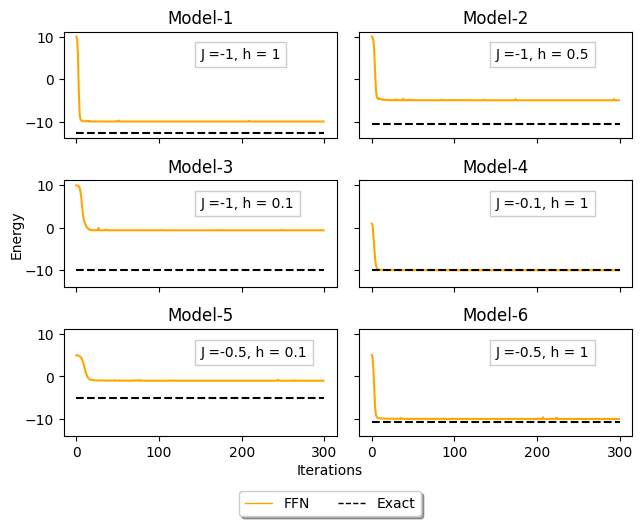

In [12]:
# visualization

fig,ax = plt.subplots(3,2,sharey=True,sharex=True)
ax = ax.flatten()

for i,keys in enumerate(models.keys()):
  model = models[keys]
  data = model['data_FFN']
  egs = model['Egs']
  ax[i].plot(data['iters'],data['Mean'],color='orange')
  ax[i].hlines([egs], xmin=0, xmax=niter, color='black',linestyle='--')
  J,h,err = model['J'],model['h'],model['error']
  ax[i].text(0.50, 0.85, f'J ={J}, h = {h}', transform=ax[i].transAxes,
               verticalalignment='top', bbox={'facecolor': 'white', 'alpha': 0.2})
  ax[i].set_title(keys)

# Create custom legend labels and handles
legend_labels = ['FFN', 'Exact']
legend_handles = [plt.Line2D([0], [0], color='orange', linewidth=1, label='FFN'),
                  plt.Line2D([0], [0], color='black', linestyle='--',linewidth=1, label='Exact')]

# Create the legend
fig.legend(handles=legend_handles, labels=legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.02),
           fancybox=True, shadow=True, ncol=2)

fig.text(0.5, 0.00, 'Iterations', ha='center')
fig.text(0.00, 0.5, 'Energy', va='center', rotation='vertical')
plt.tight_layout()

In [13]:
data = {'Model': [], 'Optimum Energy': [], 'Exact Energy':[],'Relative Error': [], "R_hat": [], 'Execution Time': []}
for keys in models.keys():
  model = models[keys]
  data['Model'].append(keys)
  data['Optimum Energy'].append("%.3f" %model['ffn_energy'].mean)
  data['Relative Error'].append("%.3f" %model['error'])
  data['Exact Energy'].append("%.3f" %model['Egs'])
  data['R_hat'].append('%.3f' %model['ffn_energy'].R_hat)
  data['Execution Time'].append(model['exec_time'])

df = pd.DataFrame(data)
df

,Model,Optimum Energy,Exact Energy,Relative Error,R_hat,Execution Time
0,Model-1,-9.999,-12.785,0.218,1.028,0:48
1,Model-2,-10.000,-10.636,0.060,1.414,0:39
2,Model-3,-6.000,-10.025,0.402,1.009,0:38
3,Model-4,-9.993,-10.025,0.003,1.414,0:40
4,Model-5,-9.998,-5.050,0.980,1.414,0:39
5,Model-6,-9.997,-10.636,0.060,1.414,0:39


In [15]:
df['Relative Error'] = df['Relative Error'].astype(float)
mean_value = df['Relative Error'].mean()

print('mean relative error',mean_value)

mean relative error 0.2871666666666667


In [16]:
print('Number of parameters to be optimized',vstate.n_parameters)

Number of parameters to be optimized 110


## <a id='toc2_2_'></a>[Ferromagnetic Models](#toc0_)

In [ ]:
N = 10 # Number of spins

models = {'Model-1':{'J':1,'h': 1}, 'Model-2':{'J':1,'h': 0.5}, 'Model-3':{'J': 1,'h': 0.1},
          'Model-4':{'J':0.1,'h': 1}, 'Model-5':{'J': 0.5, 'h': 0.1},'Model-6':{'J': 0.5, 'h': 1}}

Hamiltonian = {key: {} for key in models}

# defining hilbert space of spins-1/2
hi = nk.hilbert.Spin(s=1/2, N=N)

for keys in models.keys():
  j = models[keys]['J']
  h = models[keys]['h']
  H,hpauli = generate_Hamiltonian(N,j,h,hi)
  Egs = calc_Energy(H)
  Hamiltonian[keys]['H'] = H
  Hamiltonian[keys]['hpauli'] = hpauli
  models[keys]['Egs'] = Egs

In [ ]:
niter = 300 # max number of iterations in the optimizer

for keys in models.keys():
  model = models[keys]
  vstate.init_parameters()
  log=nk.logging.RuntimeLog()

  optimizer = nk.optimizer.Sgd(learning_rate=0.1) # using stochastic gradient descent for optimization.
  gs = nk.driver.VMC(Hamiltonian[keys]['H'],optimizer,variational_state=vstate,preconditioner=nk.optimizer.SR(diag_shift=0.1)) # build the optimization driver.
  st = time.time()
  gs.run(n_iter=niter,out=log) # runs the optimization driver for 500 iterations.
  et = time.time()
  min,sec = divmod(et-st,60)
  data_FFN = log.data # log data.
  Egs = model['Egs']
  ffn_energy = vstate.expect(H) # final energy expectation value.
  error = abs((ffn_energy.mean-Egs)/Egs) # error in energy expectation value.

  model['data_FFN'] = data_FFN['Energy'].to_dict()
  model['ffn_energy'] = ffn_energy
  model['error'] = error
  model['exec_time'] = f'{int(min)}:{int(sec)}'
  print("optimized energy and relative error",ffn_energy,error)

100%|██████████| 300/300 [00:56<00:00,  5.33it/s, Energy=-12.7777 ± 0.0023 [σ²=0.0544, R̂=0.9999]]


optimized energy and relative error -9.619 ± 0.026 [σ²=2.497, R̂=1.0039] 0.2476161484467403


100%|██████████| 300/300 [00:58<00:00,  5.14it/s, Energy=-10.63491 ± 0.00048 [σ²=0.00236, R̂=1.0009]]


optimized energy and relative error -7.285 ± 0.026 [σ²=5.598, R̂=1.0013] 0.31506481219130184


100%|██████████| 300/300 [00:56<00:00,  5.33it/s, Energy=-10.024965 ± 0.000038 [σ²=0.000014, R̂=1.0004]]


optimized energy and relative error -5.477 ± 0.031 [σ²=9.225, R̂=1.0005] 0.4536402010756915


100%|██████████| 300/300 [00:40<00:00,  7.45it/s, Energy=-10.025021 ± 0.000019 [σ²=0.000003, R̂=1.0008]]


optimized energy and relative error -10.229 ± 0.019 [σ²=1.635, R̂=1.0022] 0.020332946373293026


100%|██████████| 300/300 [00:57<00:00,  5.18it/s, Energy=-5.049989 ± 0.000076 [σ²=0.000056, R̂=1.0013]]


optimized energy and relative error -5.953 ± 0.030 [σ²=8.089, R̂=1.0009] 0.17876894189082843


100%|██████████| 300/300 [00:42<00:00,  7.11it/s, Energy=-10.63537 ± 0.00046 [σ²=0.00199, R̂=1.0009]]

optimized energy and relative error -10.63541 ± 0.00035 [σ²=0.00110, R̂=1.0009] 1.8620488593706504e-05


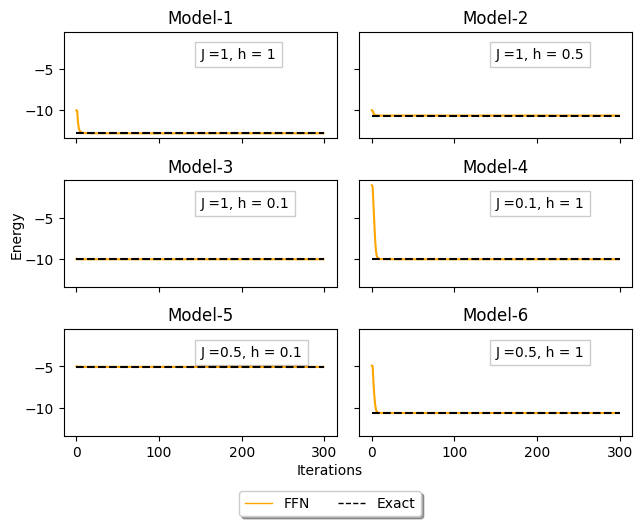

In [ ]:
# visualization

fig,ax = plt.subplots(3,2,sharey=True,sharex=True)
ax = ax.flatten()

for i,keys in enumerate(models.keys()):
  model = models[keys]
  data = model['data_FFN']
  egs = model['Egs']
  ax[i].plot(data['iters'],data['Mean'],color='orange')
  ax[i].hlines([egs], xmin=0, xmax=niter, color='black',linestyle='--')
  J,h,err = model['J'],model['h'],model['error']
  ax[i].text(0.50, 0.85, f'J ={J}, h = {h}', transform=ax[i].transAxes,
               verticalalignment='top', bbox={'facecolor': 'white', 'alpha': 0.2})
  ax[i].set_title(keys)

# Create custom legend labels and handles
legend_labels = ['FFN', 'Exact']
legend_handles = [plt.Line2D([0], [0], color='orange', linewidth=1, label='FFN'),
                  plt.Line2D([0], [0], color='black', linestyle='--',linewidth=1, label='Exact')]

# Create the legend
fig.legend(handles=legend_handles, labels=legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.02),
           fancybox=True, shadow=True, ncol=2)

fig.text(0.5, 0.00, 'Iterations', ha='center')
fig.text(0.00, 0.5, 'Energy', va='center', rotation='vertical')
plt.tight_layout()

In [ ]:
data = {'Model': [], 'Optimum Energy': [], 'Exact Energy':[],'Relative Error': [], "R_hat": [], 'Execution Time': []}
for keys in models.keys():
  model = models[keys]
  data['Model'].append(keys)
  data['Optimum Energy'].append("%.3f" %model['ffn_energy'].mean)
  data['Relative Error'].append("%.3f" %model['error'])
  data['Exact Energy'].append("%.3f" %model['Egs'])
  data['R_hat'].append('%.3f' %model['ffn_energy'].R_hat)
  data['Execution Time'].append(model['exec_time'])

df = pd.DataFrame(data)
df

,Model,Optimum Energy,Exact Energy,Relative Error,R_hat,Execution Time
0,Model-1,-9.619,-12.785,0.248,1.004,0:56
1,Model-2,-7.285,-10.636,0.315,1.001,0:58
2,Model-3,-5.477,-10.025,0.454,1.000,0:56
3,Model-4,-10.229,-10.025,0.020,1.002,0:40
4,Model-5,-5.953,-5.050,0.179,1.001,0:58
5,Model-6,-10.635,-10.636,0.000,1.001,0:42


In [ ]:
df['Relative Error'] = df['Relative Error'].astype(float)
mean_value = df['Relative Error'].mean()

print('mean relative error',mean_value)

mean relative error 0.20266666666666666


In [ ]:
print('Number of parameters to be optimized',vstate.n_parameters)

Number of parameters to be optimized 110


**Inferences - NQS**

- One layer NQS were tested for various TFI models differing $J$ and $h$ values.
- For simulation $\alpha$ value of NQS was chosen to be 1 and number of parameters to be optimized = 300.
- For ferromagnetic systems $(J = 1)$ NQS was found to be performing better with good convergence with iteration.
  - The efficiency of convergence can be estimated by using monte carlo convergence estimator $\hat{R}$.
  - For ferromagnetic models $|\hat{R}| < 1.1$ thus sampling has properly converged.

- For antiferromagnetic system, even tough relative error is low,it is found not to be converging properly for some of cases considered $|\hat{R}| > 1.1$.

- On both cases, the models for which spin-spin interaction is less (J value small) NQS performs better with relative error ~ 1%.

## <a id='toc3_'></a>[Performance analysis of Variational Quantum Algorithms](#toc0_)

`RealAmplitudes` circuit is heuristic trial wavefunction that finds application in quantum chemistry and quantum machine learning. This is one of the the simplest ansatz that could be constructed with ``qiskit`` consisting of single qubit `ry` rotation gates and `cx` entantglement blocks.

RealAmplitude ansatz for *Number of Spins* N=3, *linear* entanglement & *reps* = 2 is given below

As we change the value of reps, the number of variational parmaters need to be optimized increases. If reps = $r$ and number of spins = $N$, then, number of paramters to be optimized = $(r+1){N}$

## <a id='toc3_1_'></a>[Anti-Ferromagnetic Model](#toc0_)

In [ ]:
N = 10 # Number of spins

models = {'Model-1':{'J':-1,'h': 1}, 'Model-2':{'J':-1,'h': 0.5}, 'Model-3':{'J':-1,'h':0.1},
          'Model-4':{'J':-0.1,'h': 1}, 'Model-5':{'J':-0.5, 'h': 0.1},'Model-6':{'J':-0.5, 'h': 1}}

Hamiltonian = {key: {} for key in models}

# defining hilbert space of spins-1/2
hi = nk.hilbert.Spin(s=1/2, N=N)

for keys in models.keys():
  j = models[keys]['J']
  h = models[keys]['h']
  H,hpauli = generate_Hamiltonian(N,j,h,hi)
  Egs = calc_Energy(H)
  Hamiltonian[keys]['H'] = H
  Hamiltonian[keys]['hpauli'] = hpauli
  models[keys]['Egs'] = Egs

In [ ]:
# setting up the ansatz

backend = BasicSimulator()  # local qasm simulator is used as backend for simulatior
reps = 4 # depth of quantum circuit
pub = {keys:{} for keys in models.keys()}
for keys in models.keys():
  hpauli = Hamiltonian[keys]['hpauli']
  ansatz = RealAmplitudes(num_qubits=hpauli.num_qubits,insert_barriers=True, entanglement='linear',reps=4)
  pm = generate_preset_pass_manager(target=backend.target, optimization_level=3)
  ansatz_ibm = pm.run(ansatz)
  ham_ibm = hpauli.apply_layout(ansatz_ibm.layout)
  pub[keys]['ansatz'] = ansatz_ibm
  pub[keys]['observable'] = ham_ibm

Here while setting up the ansatz we have chosen `entanglement = linear` which put entangling gate the $i^{th}$ and ${i+1}^{th}$ qubits. It is chosen so as to satisfy the open boundary conditon.

In [ ]:
# Cost function for the optimization

def cost_func(params, ansatz, hamiltonian, estimator):
    energy = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return energy


# callback to store intermediate values of optimization

def build_callback(ansatz, hamiltonian, estimator, callback_dict):
    def callback(current_vector):
        # Keep track of the number of iterations
        callback_dict["iters"] += 1
        # Set the prev_vector to the latest one
        callback_dict["prev_vector"] = list(current_vector)
        # Compute the value of the cost function at the current vector
        # This adds an additional function evaluation
        current_cost = (
            estimator.run(ansatz, hamiltonian, parameter_values=current_vector).result().values[0]
        )
        callback_dict["cost_history"].append(current_cost)
        # Print to screen on single line
        sys.stdout.write("\rIters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost))
        sys.stdout.flush()  # Flush the output buffer

    return callback

In [ ]:
options = Options(shots=10000) # setting number of measurements for estimation of observable
estimator = BackendEstimator(backend=backend,options=options) # local estimator to calculate expectation value of the observable

In [ ]:
np.random.seed(42)
for keys in models.keys():
  model = models[keys]
  callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],}

  # setting the ansatz and the observables
  ansatz = pub[keys]['ansatz']
  observable = pub[keys]['observable']
  # finding optimal variance
  num_params = ansatz.num_parameters
  x0 = 2 * np.pi *np.random.random(num_params)


  callback = build_callback(ansatz,observable, estimator, callback_dict)
  st = time.time()
  res = minimize(cost_func,x0,
    args=(ansatz, observable, estimator),
    method="cobyla", # algorithm for optimization is cobyla
    callback=callback,
    options={'maxiter':niter},)
  et = time.time()
  min,sec = divmod(et-st,60)

  model['data_RAmp'] = callback_dict
  model['exec_time'] = f'{int(min)}:{int(sec)}'

  # optimal energy calculation
  opt_ansatz = ansatz.assign_parameters(parameters = callback_dict['prev_vector'])
  res = estimator.run(circuits=[opt_ansatz]*100, observables=[observable]*100)
  eopt = res.result().values.mean()
  energy_exact = model['Egs']
  model['RAmp_energy'] = eopt
  error = abs((eopt - energy_exact)/energy_exact)
  model['error'] = error
  print("optimized energy and relative error",eopt,error)

Iters. done: 301 [Current cost: -9.918199999999999]optimized energy and relative error -9.91199 0.22471157343294132
Iters. done: 301 [Current cost: -8.6746]optimized energy and relative error -8.641017999999999 0.18753860453806165
Iters. done: 301 [Current cost: -9.426680000000001]optimized energy and relative error -9.4398352 0.058372024925807835
Iters. done: 301 [Current cost: -8.5327]optimized energy and relative error -8.5088696 0.15123627882631482
Iters. done: 301 [Current cost: -4.36714]optimized energy and relative error -4.3863884 0.1314299569062678
Iters. done: 301 [Current cost: -7.765499999999999]optimized energy and relative error -7.702952999999999 0.27573904561271123


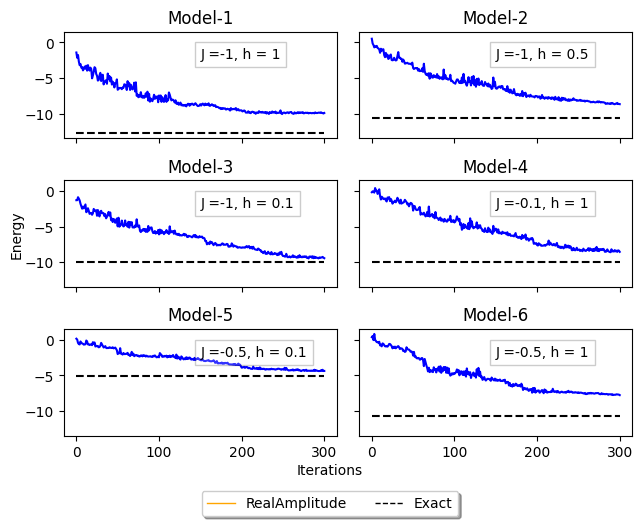

In [ ]:
# visualization

fig,ax = plt.subplots(3,2,sharey=True,sharex=True)
ax = ax.flatten()

for i,keys in enumerate(models.keys()):
  model = models[keys]
  data = model['data_RAmp']
  egs = model['Egs']
  ax[i].plot(range(data['iters']),data['cost_history'],color='blue')
  ax[i].hlines([egs], xmin=0, xmax=niter, color='black',linestyle='--')
  J,h,err = model['J'],model['h'],model['error']
  ax[i].text(0.50, 0.85, f'J ={J}, h = {h}', transform=ax[i].transAxes,
               verticalalignment='top', bbox={'facecolor': 'white', 'alpha': 0.2})
  ax[i].set_title(keys)

# Create custom legend labels and handles
legend_labels = ['RealAmplitude', 'Exact']
legend_handles = [plt.Line2D([0], [0], color='orange', linewidth=1, label='RealAmplitude'),
                  plt.Line2D([0], [0], color='black', linestyle='--',linewidth=1, label='Exact')]

# Create the legend
fig.legend(handles=legend_handles, labels=legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.02),
           fancybox=True, shadow=True, ncol=2)

fig.text(0.5, 0.00, 'Iterations', ha='center')
fig.text(0.00, 0.5, 'Energy', va='center', rotation='vertical')
plt.tight_layout()

In [ ]:
data = {'Model': [], 'Optimum Energy': [], 'Exact Energy':[],'Relative Error': [], 'Execution Time': []}
for keys in models.keys():
  model = models[keys]
  data['Model'].append(keys)
  data['Optimum Energy'].append("%.3f" %model['RAmp_energy'])
  data['Relative Error'].append("%.3f" %model['error'])
  data['Exact Energy'].append("%.3f" %model['Egs'])
  data['Execution Time'].append(model['exec_time'])

df = pd.DataFrame(data)
df

,Model,Optimum Energy,Exact Energy,Relative Error,Execution Time
0,Model-1,-9.912,-12.785,0.225,2:18
1,Model-2,-8.641,-10.636,0.188,2:13
2,Model-3,-9.440,-10.025,0.058,2:13
3,Model-4,-8.509,-10.025,0.151,2:14
4,Model-5,-4.386,-5.050,0.131,2:13
5,Model-6,-7.703,-10.636,0.276,2:12


In [ ]:
df['Relative Error'] = df['Relative Error'].astype(float)
mean_value = df['Relative Error'].mean()

print('mean relative error',mean_value)

mean relative error 0.17149999999999999


In [ ]:
print('Number of parameters to be optimized',ansatz.num_parameters)

Number of parameters to be optimized 50


## <a id='toc3_2_'></a>[Ferromagnetic](#toc0_)

In [ ]:
N = 10 # Number of spins

models = {'Model-1':{'J':1,'h': 1}, 'Model-2':{'J':1,'h': 0.5}, 'Model-3':{'J': 1,'h': 0.1},
          'Model-4':{'J':0.1,'h': 1}, 'Model-5':{'J': 0.5, 'h': 0.1},'Model-6':{'J': 0.5, 'h': 1}}

Hamiltonian = {key: {} for key in models}

# defining hilbert space of spins-1/2
hi = nk.hilbert.Spin(s=1/2, N=N)

for keys in models.keys():
  j = models[keys]['J']
  h = models[keys]['h']
  H,hpauli = generate_Hamiltonian(N,j,h,hi)
  Egs = calc_Energy(H)
  Hamiltonian[keys]['H'] = H
  Hamiltonian[keys]['hpauli'] = hpauli
  models[keys]['Egs'] = Egs

In [ ]:
# setting up the ansatz

backend = BasicSimulator()  # local qasm simulator is used as backend for simulatior
pub = {keys:{} for keys in models.keys()}
for keys in models.keys():
  hpauli = Hamiltonian[keys]['hpauli']
  ansatz = RealAmplitudes(num_qubits=hpauli.num_qubits,insert_barriers=True, entanglement='linear',reps=4) # for PBC, the entanglement is taken as closed
  pm = generate_preset_pass_manager(target=backend.target, optimization_level=3)
  ansatz_ibm = pm.run(ansatz)
  ham_ibm = hpauli.apply_layout(ansatz_ibm.layout)
  pub[keys]['ansatz'] = ansatz_ibm
  pub[keys]['observable'] = ham_ibm

In [ ]:
options = Options(shots=10000) # setting number of measurements for estimation of observable
estimator = BackendEstimator(backend=backend,options=options)
np.random.seed(42)

for keys in models.keys():
  model = models[keys]
  callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],}

  # setting the ansatz and the observables
  ansatz = pub[keys]['ansatz']
  observable = pub[keys]['observable']
  # finding optimal variance
  num_params = ansatz.num_parameters
  x0 = 2 * np.pi *np.random.random(num_params)


  callback = build_callback(ansatz,observable, estimator, callback_dict)
  st = time.time()
  res = minimize(cost_func,x0,
    args=(ansatz, observable, estimator),
    method="cobyla",
    callback=callback,
    options={'maxiter':niter},)
  et = time.time()
  min,sec = divmod(et-st,60)

  model['data_RAmp'] = callback_dict
  model['exec_time'] = f'{int(min)}:{int(sec)}'

  # optimal energy calculation
  opt_ansatz = ansatz.assign_parameters(parameters = callback_dict['prev_vector'])
  res = estimator.run(circuits=[opt_ansatz]*100, observables=[observable]*100)
  eopt = res.result().values.mean()
  energy_exact = model['Egs']
  model['RAmp_energy'] = eopt
  error = abs((eopt - energy_exact)/energy_exact)
  model['error'] = error
  print("optimized energy and relative error",eopt,error)

Iters. done: 301 [Current cost: -11.390799999999999]optimized energy and relative error -11.342637999999999 0.11281024616250475
Iters. done: 301 [Current cost: -9.040000000000001]optimized energy and relative error -9.083657999999998 0.14591990728650323
Iters. done: 301 [Current cost: -7.32908]optimized energy and relative error -7.3380088 0.2680301910969155
Iters. done: 301 [Current cost: -4.8331]optimized energy and relative error -4.8305202000000005 0.5181533513973866
Iters. done: 301 [Current cost: -4.293639999999999]optimized energy and relative error -4.3002861999999995 0.1484794711637085
Iters. done: 301 [Current cost: -9.414100000000001]optimized energy and relative error -9.418347999999998 0.11445107983501965


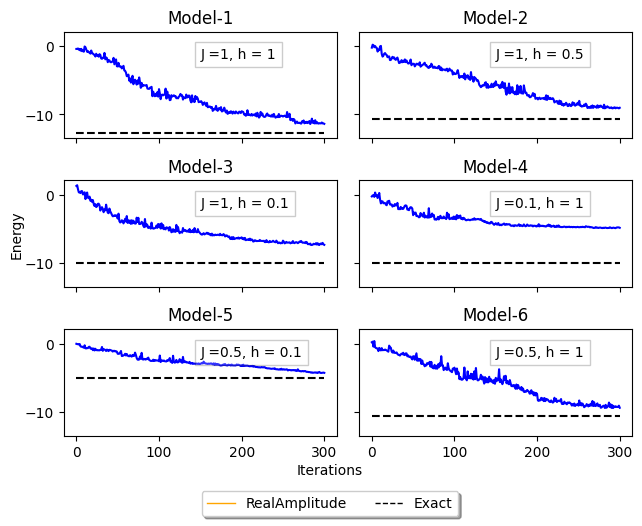

In [ ]:
# visualization

fig,ax = plt.subplots(3,2,sharey=True,sharex=True)
ax = ax.flatten()

for i,keys in enumerate(models.keys()):
  model = models[keys]
  data = model['data_RAmp']
  egs = model['Egs']
  ax[i].plot(range(data['iters']),data['cost_history'],color='blue')
  ax[i].hlines([egs], xmin=0, xmax=niter, color='black',linestyle='--')
  J,h,err = model['J'],model['h'],model['error']
  ax[i].text(0.50, 0.85, f'J ={J}, h = {h}', transform=ax[i].transAxes,
               verticalalignment='top', bbox={'facecolor': 'white', 'alpha': 0.2})
  ax[i].set_title(keys)

# Create custom legend labels and handles
legend_labels = ['RealAmplitude', 'Exact']
legend_handles = [plt.Line2D([0], [0], color='orange', linewidth=1, label='RealAmplitude'),
                  plt.Line2D([0], [0], color='black', linestyle='--',linewidth=1, label='Exact')]

# Create the legend
fig.legend(handles=legend_handles, labels=legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.02),
           fancybox=True, shadow=True, ncol=2)

fig.text(0.5, 0.00, 'Iterations', ha='center')
fig.text(0.00, 0.5, 'Energy', va='center', rotation='vertical')
plt.tight_layout()

In [ ]:
data = {'Model': [], 'Optimum Energy': [], 'Exact Energy':[],'Relative Error': [], 'Execution Time': []}
for keys in models.keys():
  model = models[keys]
  data['Model'].append(keys)
  data['Optimum Energy'].append("%.3f" %model['RAmp_energy'])
  data['Relative Error'].append("%.3f" %model['error'])
  data['Exact Energy'].append("%.3f" %model['Egs'])
  data['Execution Time'].append(model['exec_time'])

df = pd.DataFrame(data)
df

,Model,Optimum Energy,Exact Energy,Relative Error,Execution Time
0,Model-1,-11.343,-12.785,0.113,2:11
1,Model-2,-9.084,-10.636,0.146,2:12
2,Model-3,-7.338,-10.025,0.268,2:12
3,Model-4,-4.831,-10.025,0.518,2:13
4,Model-5,-4.300,-5.050,0.148,2:13
5,Model-6,-9.418,-10.636,0.114,2:13


In [ ]:
df['Relative Error'] = df['Relative Error'].astype(float)
mean_value = df['Relative Error'].mean()

print('mean relative error',mean_value)

mean relative error 0.21783333333333332


In [ ]:
print('Number of parameters to be optimized',ansatz.num_parameters)

Number of parameters to be optimized 50


**Inferences - VQA**

*   Both antiferromagnetic model and Ferromagnetic model was tested using RealAmplitude Ansatz.
*   Compared to ferromagnetic models, the anti-ferromagnetic models have better convergence from considering only the relative error as a metric.
*   Increasing the number of iterations was found to be giving better convergence and less relative error.

        Results for antiferomagnetic and ferromagnetic models for number of optimization = 600


<img src=".\vqa_data\10spins\antiferromagnetic\image_antiferomagnetic_10spins_4reps_600iterations.png" alt="Image 1" style="width: 45%; margin-right: 5px;" title="antiferromagnetic"> 
<img src=".\vqa_data\10spins\ferromagnetic\image_feromagnetic_10spins_4reps_600iterations.png" alt="Image 2" title="Title 2" style="width: 45%; margin-left: 5px;">

# <a id='toc3_3_'></a>[**Conclusion & Dicussion**](#toc0_)

1. Performance One-Layer FFN and RealAmplitude Quantum ansatz was tested on TFI model with 10 spins subjected to open boundary condtions,by varying $J$ and $h$ value.

2. In both approaches, the optimization algorithm used was different.
    *  For NQS, Stochastic gradient descent was used to perform the parmeter updation.
    * For VQA, COBYLA was used for parameter updation. It is a gradient free optimization algorithm used in constrained optimization.
    * Gradient Based optimization in Qiskit is found to be not working well BackendEstimator, requires full statevector simulators to carryout the optimization.
    * In both cases, the number of iterations of the optimization algorithm was fixed **for 300 iterations** unless specified.
    * Results from a variational algorithms depends upon optimization algorithms used. This study does not look into the influence of optimization routine on the results.

3. In terms of relative error, both of approaches have comparable performances (on the basis of mean relative error).
    * But NQS seems to face trouble while finding ground state of antiferromagnetic models.
    * For most of the models, NQS have $|\hat{R}| >1.1$ which indicates the non-convergence of the algorithm. 
    * Trails were conducted by increasing the *number of iterations* and *alpha* values. Results are given below:

<p>Results for antiferromagntic model alpha = 1, iterations = 500</p>
<img src=".\images\table_antiferromagnetic_10spins_1alpha_500iterations.png" alt="Image 1" style="width: 45%; margin-right: 5px;" title="antiferromagnetic"> 

<p>Results for antiferromagntic model alpha = 2, iterations = 300</p>
<img src=".\images\table_antiferromagnetic_10spins_2alpha_300iterations.png" alt="Image 2" title="Title 2" style="width: 45%; margin-left: 5px;">

* Increasing number of iterations and alpha value doesnot seems to makes the algorithm converging, and also makes the execution time larger.

4. VQA have **nearly half the parameters to be optimized compared to NQS still the time taken for the convergence is more than 2 folds**.
    * This indicates the immense resource requirement in the case of VQA while running it on a simulator.
    * An alternative is to running it on real hardware.


5. **With increasing number of spins, both variational ansatzes found to be ill-suited for representing the ground state of the system**.

<p>NQS: antiferromagntic model (alpha = 1, iterations = 300, N = 15)</p>
<img src=".\images\table_antiferromagnet_15spins_1alpha_300iterations.png" alt="Image 1" style="width: 45%; margin-right: 5px;" title="antiferromagnetic"> 

<p>RealAmplitudes: antiferromagntic model (reps = 4, iterations = 300, N = 15)</p>
<img src=".\images\table_antiferromagnet_15spins_4reps_300iterations.png" alt="Image 1" style="width: 45%; margin-right: 5px;" title="antiferromagnetic"> 

- RealAmplitude ansatz was getting better with increase in number of iterations, but on the downside execution time was larger.

In [ ]:
# device specifications
!lscpu

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         46 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  2
  On-line CPU(s) list:   0,1
Vendor ID:               GenuineIntel
  Model name:            Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:          6
    Model:               79
    Thread(s) per core:  2
    Core(s) per socket:  1
    Socket(s):           1
    Stepping:            0
    BogoMIPS:            4399.99
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clf
                         lush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_
                         good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fm
                         a cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hyp
                         ervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd i

In [ ]:
# version specifications

import netket
import qiskit

modules = {'modules': ['qiskit','netket'], 'version': [qiskit.__version__,netket.__version__]}
pd.DataFrame(modules)

,modules,version
0,qiskit,1.0.2
1,netket,3.11.2
